# BioE C142 Final Ugrad Project Checkpoint 3 - Qile Yang

The instructions for this checkpoint are as follows: Regularization strategies and hyperparameter tuning. Use more data to train the network. Play with the architecture, hyperparameters and the regularization strategies. Show your work and defend the final choice of your model.

In [1]:
# notebook and python env setup
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchani
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

/home/qile/miniconda3/lib/python3.12/site-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")
/home/qile/miniconda3/lib/python3.12/site-packages/torchani/__init__.py:55: UserWarning: Dependency not satisfied, torchani.ase will not be available
  warnings.warn("Dependency not satisfied, torchani.ase will not be available")


cuda


## Loading previous data and functions from checkpoints 1 and 2

In [2]:
# loading data and default energy computers

def init_aev_computer():
    Rcr = 5.2
    Rca = 3.5
    EtaR = torch.tensor([16], dtype=torch.float, device=device)
    ShfR = torch.tensor([
        0.900000, 1.168750, 1.437500, 1.706250, 
        1.975000, 2.243750, 2.512500, 2.781250, 
        3.050000, 3.318750, 3.587500, 3.856250, 
        4.125000, 4.393750, 4.662500, 4.931250
    ], dtype=torch.float, device=device)


    EtaA = torch.tensor([8], dtype=torch.float, device=device)
    Zeta = torch.tensor([32], dtype=torch.float, device=device)
    ShfA = torch.tensor([0.90, 1.55, 2.20, 2.85], dtype=torch.float, device=device)
    ShfZ = torch.tensor([
        0.19634954, 0.58904862, 0.9817477, 1.37444680, 
        1.76714590, 2.15984490, 2.5525440, 2.94524300
    ], dtype=torch.float, device=device)

    num_species = 4
    aev_computer = torchani.AEVComputer(
        Rcr, Rca, EtaR, ShfR, EtaA, Zeta, ShfA, ShfZ, num_species
    )
    return aev_computer

aev_computer = init_aev_computer()
aev_dim = aev_computer.aev_length

def load_ani_dataset(dspath):
    self_energies = torch.tensor([ # this was in the original code, but the variable isn't used?
        0.500607632585, -37.8302333826,
        -54.5680045287, -75.0362229210
    ], dtype=torch.float, device=device)
    energy_shifter = torchani.utils.EnergyShifter(None)
    species_order = ['H', 'C', 'N', 'O']

    dataset = torchani.data.load(dspath)
    dataset = dataset.subtract_self_energies(energy_shifter, species_order)
    dataset = dataset.species_to_indices(species_order)
    dataset = dataset.shuffle()
    return dataset

dataset = load_ani_dataset("./data/ani_gdb_s01_to_s04.h5")
train_data, val_data, test_data = dataset.split(0.8, 0.1, 0.1)
print(len(train_data))

691918


In [3]:
# defining the trainer

class ANITrainer:
    def __init__(self, model, batch_size, learning_rate, epoch, l2):
        self.model = model
        
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
        
        self.batch_size = batch_size
        self.optimizer = torch.optim.Adam(
            model.parameters(), lr=learning_rate, weight_decay=l2
        )
        self.epoch = epoch
    
    def train(self, train_data, val_data, early_stop=True, draw_curve=True):
        self.model.train()
        
        # init data loader
        print("Initialize training data...")
        train_data_loader = train_data.collate(self.batch_size).cache()
        train_data_len = len(train_data)
        
        # definition of loss function: MSE is a good choice! 
        loss_func = nn.MSELoss()
        
        # record epoch losses
        train_loss_list = []
        val_loss_list = []
        lowest_val_loss = np.inf
        
        for i in tqdm(range(self.epoch), leave=True):
            train_epoch_loss = 0.0
            for train_data_batch in train_data_loader:
                
                # compute energies
                true_energies = train_data_batch["energies"].to(device).float()
                
                # compute loss
                batch_loss = loss_func(
                    true_energies,
                    self.model((
                        train_data_batch['species'].to(device),
                        train_data_batch['coordinates'].to(device)
                    ))[1]
                )
                
                # do a step
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                
                batch_importance = len(train_data_batch) / train_data_len
                train_epoch_loss += batch_loss.item() * batch_importance
            
            # use the self.evaluate to get loss on the validation set 
            val_epoch_loss = self.evaluate(val_data, draw_plot=False)
            
            # append the losses
            train_loss_list.append(train_epoch_loss)
            val_loss_list.append(val_epoch_loss)
            
            if early_stop:
                if val_epoch_loss < lowest_val_loss:
                    lowest_val_loss = val_epoch_loss
                    weights = self.model.state_dict()
        
        if draw_curve:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.set_yscale("log")
            # Plot train loss and validation loss
            epochs = np.arange(self.epoch)
            ax.plot(epochs, train_loss_list, label='Train')
            ax.plot(epochs, val_loss_list, label='Validation')
            ax.legend()
            ax.set_xlabel("# Batch")
            ax.set_ylabel("Loss")
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return train_loss_list, val_loss_list
    
    
    def evaluate(self, data, draw_plot=False):
        
        # init data loader
        data_loader = data.collate(self.batch_size).cache()
        data_len = len(data)
        
        # init loss function
        loss_func = nn.MSELoss()
        total_loss = 0.0
        
        if draw_plot:
            true_energies_all = []
            pred_energies_all = []
            
        with torch.no_grad():
            for batch_data in data_loader:
                
                # compute energies
                true_energies = batch_data["energies"].to(device).float()
                _, pred_energies = self.model((
                    batch_data['species'].to(device),
                    batch_data['coordinates'].to(device)
                ))

                # compute loss
                batch_loss = loss_func(true_energies, pred_energies)

                batch_importance = len(batch_data) / data_len
                total_loss += batch_loss.item() * batch_importance
                
                if draw_plot:
                    true_energies_all.append(true_energies.detach().cpu().numpy().flatten())
                    pred_energies_all.append(pred_energies.detach().cpu().numpy().flatten())

        if draw_plot:
            true_energies_all = np.concatenate(true_energies_all)
            pred_energies_all = np.concatenate(pred_energies_all)
            # Report the mean absolute error
            # The unit of energies in the dataset is hartree
            # please convert it to kcal/mol when reporting the mean absolute error
            # 1 hartree = 627.5094738898777 kcal/mol
            # MAE = mean(|true - pred|)
            hartree2kcalmol = (true_energies_all - pred_energies_all) * 627.5094738898777
            mae = np.mean(np.abs(hartree2kcalmol))
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.scatter(true_energies_all, pred_energies_all, label=f"MAE: {mae:.2f} kcal/mol", s=2)
            ax.set_xlabel("Ground Truth")
            ax.set_ylabel("Predicted")
            xmin, xmax = ax.get_xlim()
            ymin, ymax = ax.get_ylim()
            vmin, vmax = min(xmin, ymin), max(xmax, ymax)
            ax.set_xlim(vmin, vmax)
            ax.set_ylim(vmin, vmax)
            ax.plot([vmin, vmax], [vmin, vmax], color='red')
            ax.legend()

        return total_loss


## Actual Checkpoint 3 Content

The overarching goal is to create a better model through either changing the arcitecture or hyperparameters. (including regularization as a hyperparam) I will do this by defining several models, training on the same data, and doing grid searches on the hyperparameters. I will then compare the results and select the best one and justify it.

In [4]:
# here I'll define a helper to create the model
from collections.abc import Callable

def create_model(model_class: Callable) -> nn.Module:
    net_H = model_class()
    net_C = model_class()
    net_N = model_class()
    net_O = model_class()
    ani_net = torchani.ANIModel([net_H, net_C, net_N, net_O])
    return nn.Sequential(
        aev_computer,
        ani_net
    ).to(device)

Sequential - Number of parameters: 197636
Initialize training data...


100%|██████████| 25/25 [04:39<00:00, 11.16s/it]


([1.2465504396901702e-06,
  2.2678864135099367e-07,
  1.7058989237444918e-07,
  1.501053482171178e-07,
  1.4035157875219336e-07,
  1.346598813235385e-07,
  1.307402957749113e-07,
  1.2784440095651858e-07,
  1.258062944444608e-07,
  1.2425975768235314e-07,
  1.2297995978324728e-07,
  1.220126617441242e-07,
  1.2124046339078106e-07,
  1.2042868013618726e-07,
  1.1994663259930604e-07,
  1.1950712058532708e-07,
  1.193302921740873e-07,
  1.1920639890505795e-07,
  1.1905629112632518e-07,
  1.1891819667006453e-07,
  1.1882464582352847e-07,
  1.1869242365051007e-07,
  1.1856040589356291e-07,
  1.1843171926917325e-07,
  1.1830604182538117e-07],
 [2.947694387917272e-07,
  1.8997643047885865e-07,
  1.5548565485899282e-07,
  1.4266836623674343e-07,
  1.391623036269318e-07,
  1.362081275843061e-07,
  1.342467617586108e-07,
  1.3130675380718249e-07,
  1.2798875466713456e-07,
  1.2508675602081396e-07,
  1.2326350810541804e-07,
  1.2176776711952107e-07,
  1.207216963653861e-07,
  1.2011868822293632e-

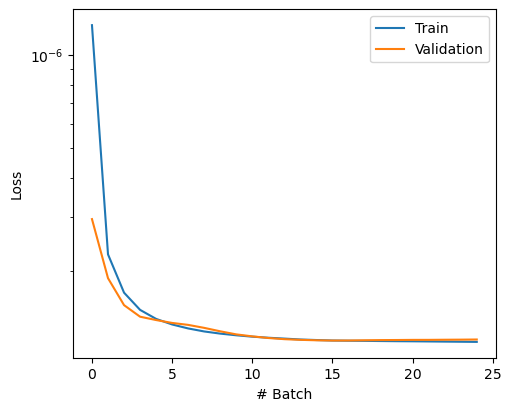

In [ ]:
# I will start off by using the "naive" model from last time as a baseline and try to iteratively improve.
class SingleHiddenLayerFc(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(aev_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.layers(x)
    
trainer = ANITrainer(
    model=create_model(SingleHiddenLayerFc),
    batch_size=1024,
    learning_rate=1e-4,
    epoch=25,
    l2=1e-4
)

trainer.train(train_data=train_data, val_data=val_data, early_stop=True, draw_curve=True)

1.2690700745880507e-07

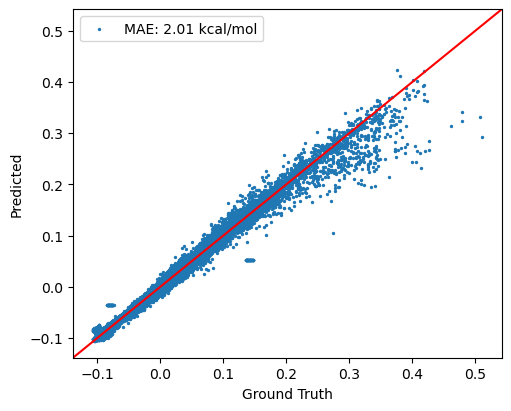

In [ ]:
trainer.evaluate(test_data, draw_plot=True)

This is essentially a slightly better version of the results from checkpoint 2 since I let it run for more epochs, and we have a decent baseline of around 2kcal/mol MAE and it appears visually quite good especially for lower energies but starts to get a bit worse at higher energies. I think the arcitecture can benefit from some more complexity before I start tweaking hyperparams.

I'll try adding more layers and using GeLU instead of ReLU.

Sequential - Number of parameters: 977828
Initialize training data...


100%|██████████| 25/25 [06:21<00:00, 15.24s/it]


([4.002437015377311e-06,
  8.386218819341755e-07,
  6.650336298272296e-07,
  6.155004069541085e-07,
  5.90607669058741e-07,
  5.727100154542911e-07,
  5.575507802970219e-07,
  5.43690866118332e-07,
  5.308298292608427e-07,
  5.190175474351742e-07,
  5.083618554462902e-07,
  4.98906235090231e-07,
  4.905993482554083e-07,
  4.833316957220409e-07,
  4.769804034858943e-07,
  4.714218132866225e-07,
  4.6653681059645166e-07,
  4.622255019764268e-07,
  4.5841424066725414e-07,
  4.550477162023557e-07,
  4.520832740086884e-07,
  4.494665553898611e-07,
  4.4713342128807143e-07,
  4.450200436664752e-07,
  4.4306934079430287e-07],
 [1.0603457821986012e-06,
  7.274927291676705e-07,
  6.558550872832143e-07,
  6.257232582953979e-07,
  5.894984146648261e-07,
  5.717165141752426e-07,
  5.573328827970781e-07,
  5.441328193610218e-07,
  5.320497358448468e-07,
  5.212135034103647e-07,
  5.11743737609531e-07,
  5.037234047512452e-07,
  4.97160163481454e-07,
  4.919639107618677e-07,
  4.879472384207583e-07,

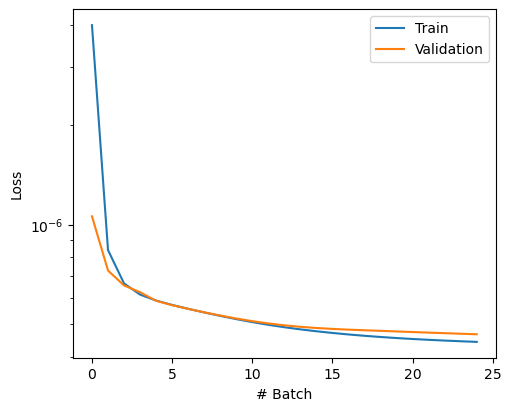

In [ ]:
class Linear2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(aev_dim, 300),
            nn.GELU(),
            nn.Linear(300, 300),
            nn.GELU(),
            nn.Linear(300, 128),
            nn.GELU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.layers(x)
    
trainer2 = ANITrainer(
    model=create_model(Linear2),
    batch_size=1024,
    learning_rate=1e-4,
    epoch=25,
    l2=1e-4
)

trainer2.train(train_data=train_data, val_data=val_data, early_stop=True, draw_curve=True)

4.90271191514622e-07

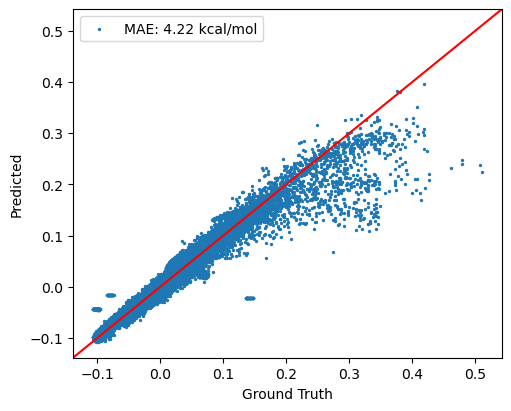

In [24]:
trainer2.evaluate(test_data, draw_plot=True)

We see that we actually have much worse results than before. I think this is because the model is overfitting. I will try adding dropout, more L2 regularization, and a residual connection. I will also try using a smaller learning rate and more epochs to see if that helps.

Sequential - Number of parameters: 1339028
Initialize training data...


100%|██████████| 25/25 [06:17<00:00, 15.10s/it]


([7.314995101220318e-06,
  5.758001603371622e-07,
  3.7562003710583025e-07,
  3.0380039539206753e-07,
  2.6649644672517406e-07,
  2.423898070895316e-07,
  2.257499107195698e-07,
  2.1377854140637306e-07,
  2.0508561257759156e-07,
  1.9855675702923102e-07,
  1.9380633085775306e-07,
  1.8968056792693e-07,
  1.868379971136979e-07,
  1.8535096613881148e-07,
  1.8477862290722623e-07,
  1.8397218541010904e-07,
  1.8389128257826826e-07,
  1.8365592744595476e-07,
  1.8315439992267632e-07,
  1.828881744067199e-07,
  1.8223434993075295e-07,
  1.8031232171439813e-07,
  1.8022770161585719e-07,
  1.789666188326135e-07,
  1.7796920478314948e-07],
 [8.098137836437202e-07,
  4.537268645382835e-07,
  3.453848883773454e-07,
  2.945352149825139e-07,
  2.6423118028312497e-07,
  2.4522194354540735e-07,
  2.3162097248087414e-07,
  2.199413463625032e-07,
  2.1182064501335147e-07,
  2.0828079644569165e-07,
  2.0216237042275248e-07,
  1.9826185530546958e-07,
  1.9480778882186305e-07,
  1.9355353172404605e-07,


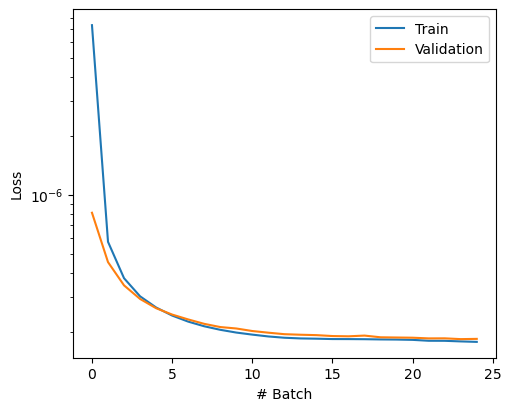

In [ ]:
class Linear3(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(aev_dim, 300)
        self.hidden = nn.Sequential(
            nn.Linear(300, 300),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(300, 300),
            nn.GELU(),
            nn.Dropout(0.1)
        )
        self.output = nn.Sequential(
            nn.Linear(300, 128),
            nn.GELU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.input(x)
        x = x + self.hidden(x)
        return self.output(x)
    
trainer3 = ANITrainer(
    model=create_model(Linear3),
    batch_size=1048,
    learning_rate=1e-4,
    epoch=25,
    l2=1e-4
)

trainer3.train(train_data=train_data, val_data=val_data, early_stop=True, draw_curve=True)

1.9146099057609184e-07

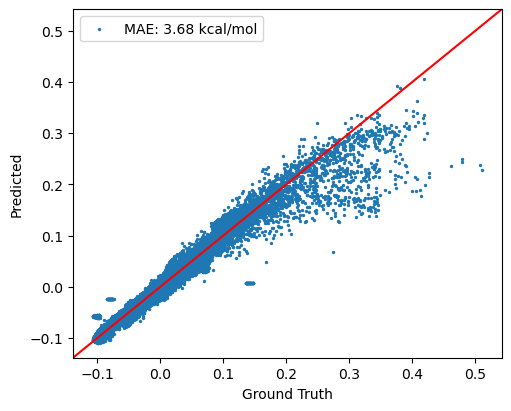

In [29]:
trainer3.evaluate(test_data, draw_plot=True)

Results are slightly better but once again we seem to be overfitting the training set. The layer dropout and residual connection was not even good enough to learn the identity function of the first model (likely also due to not having a residual connection on every layer) and overall the performance is still worse than the simple single hidden layer feedforward neetwork. Looks like the limit of a feedward network is probably reached. Now I will try completely different arcitectures.

I think an important aspect of molecules is both their local and global structure and relationships. So I think something that cares about dependencies between everything like CNNs, GNNs, RNNs, or Transformers would be a good idea. I'll go wild here and try a transformer-type model first with silu (even though its quite similar to GELU) and also a "residualized" version of the first Linear network.

Sequential - Number of parameters: 990724
Initialize training data...


100%|██████████| 10/10 [08:19<00:00, 49.92s/it]


([0.0005239606982765932,
  2.0213651163599706e-05,
  1.8205582083521692e-05,
  1.5684367292104863e-05,
  1.1519008106299417e-05,
  9.238182425549065e-06,
  7.070762719481344e-06,
  6.213949373054096e-06,
  5.327678000663167e-06,
  4.817757830677287e-06],
 [2.0256661346144776e-05,
  7.420043967217192e-06,
  9.259312959801887e-06,
  1.0109170662010973e-05,
  9.415366242324786e-06,
  1.7939412993255852e-06,
  4.22814778728195e-06,
  1.9985270880741904e-06,
  6.381599776303322e-06,
  3.1986797293004947e-06])

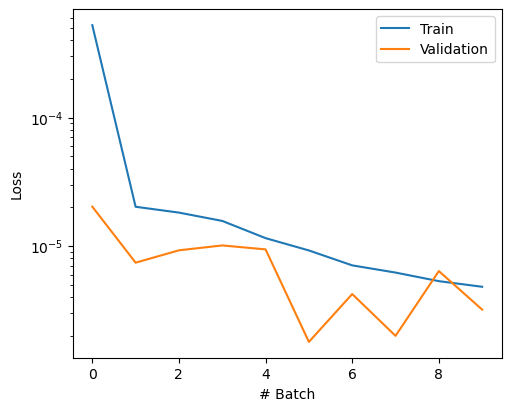

In [36]:
class AttentionANI(nn.Module):
    def __init__(self, input_dim=aev_dim, hidden_dim=128, num_heads=2, output_dim=1):
        super(AttentionANI, self).__init__()
        
        self.input_projection = nn.Linear(input_dim, hidden_dim)
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.SiLU(),
            nn.Linear(hidden_dim * 4, hidden_dim)
        )
        
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.input_projection(x)
        attn_out, _ = self.attention(x, x, x)
        x = self.norm1(x + attn_out)
        fc_out = self.fc(x)
        x = self.norm2(x + fc_out)
        return self.output_layer(x)

# I'll first train for 10 epochs, if promising I'll keep training
trainer4 = ANITrainer(
    model=create_model(AttentionANI),
    batch_size=1048/2,
    learning_rate=1e-4,
    epoch=10,
    l2=1e-4
)

trainer4.train(train_data=train_data, val_data=val_data, early_stop=True, draw_curve=True)

3.2752770894536247e-06

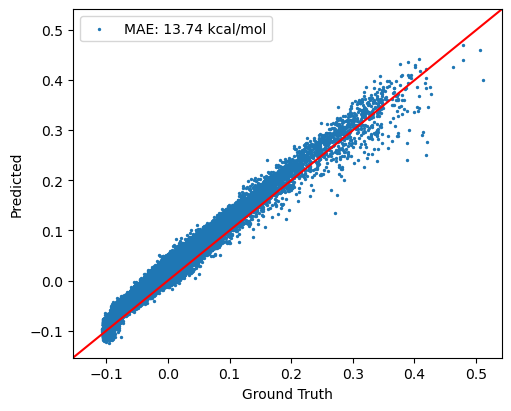

In [37]:
trainer4.evaluate(test_data, draw_plot=True)

There seems to be some weird bias in the model. I'll keep training for 10 epochs to see if it gets better. So far it's not even performing as well as the simple feedforward networks.

Initialize training data...


100%|██████████| 10/10 [08:14<00:00, 49.46s/it]


([4.330486126538374e-06,
  4.017445643865163e-06,
  3.4444346848296637e-06,
  3.3169244233419105e-06,
  3.0809359072446324e-06,
  2.9947168936339064e-06,
  2.7415059821102644e-06,
  2.497794425303255e-06,
  2.3234742188458655e-06,
  2.173613924337111e-06],
 [1.6453713744996555e-06,
  4.455404666649915e-06,
  5.084323736617962e-06,
  1.7375527915244996e-06,
  6.235550145137897e-07,
  1.7812464236068916e-06,
  2.9973093092051237e-06,
  1.1877702638028306e-06,
  7.822204593680848e-07,
  1.6866194476876965e-06])

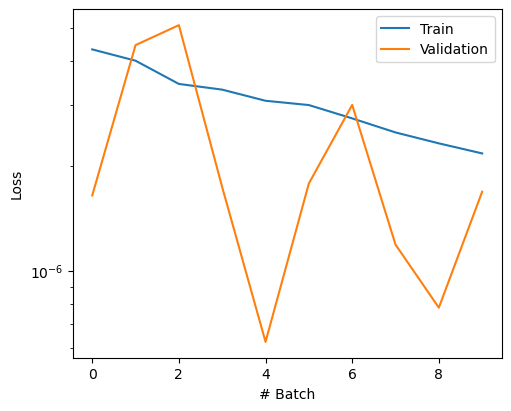

In [39]:
trainer4.train(train_data=train_data, val_data=val_data, early_stop=True, draw_curve=True)

1.731531688553797e-06

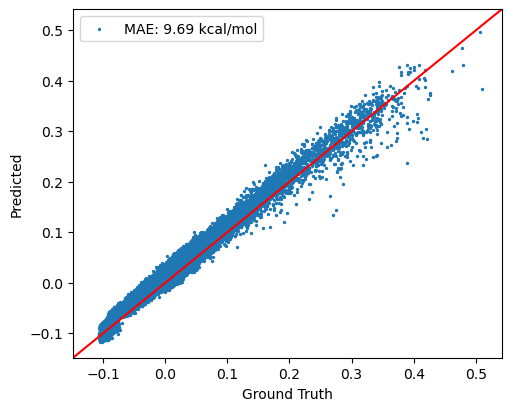

In [40]:
trainer4.evaluate(test_data, draw_plot=True)

Again the MAE decreased and we can visually see the bias decreasing. From the loss graph we see that training loss is gradially decreasing with a somewhat unstable but also decreasing-on-average test loss. Even looking at the most upper samples we see that there is for sure slightly less variance in those samples so I think this model actually has a decent chance at being good but converges very slowly compared to the feedforward networks.

I think there isn't too much point in trying too many complex arcitectures as of right now with the limited time and resources I have to train the model. Also looking at other papers, authors generally just used simple feedforward networks with some hidden layers. I'll just settle on a feedforward network and grid search over some regularization values and hyperparameters since at the end of the day the ANI arcitecture will just sum everything.

## Defining the model and searching over hyperparameters and regularization amounts

- I'll try to tune for L2 regularization, batch size, and learning rate.

In [ ]:
class FeedForwardANI(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(aev_dim, 128),
            nn.CELU(alpha=0.1),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

# these are reasonable ranges for reference
l2 = [0.0, 1e-2, 1e-3, 1e-4, 1e-5]
batch_size = [1024, 2048, 4096, 8162]
learn_rate = [1e-2, 1e-3, 1e-4]

I am aware that I can do an automated grid search, but I'll do it manually because I'll have human intuition on what the results mean and how I can direct the search iteratively.

Sequential - Number of parameters: 197636
Initialize training data...


100%|██████████| 30/30 [04:07<00:00,  8.25s/it]


2.0383374194524476e-08

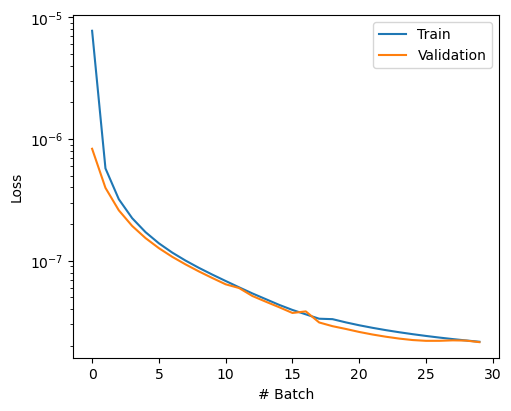

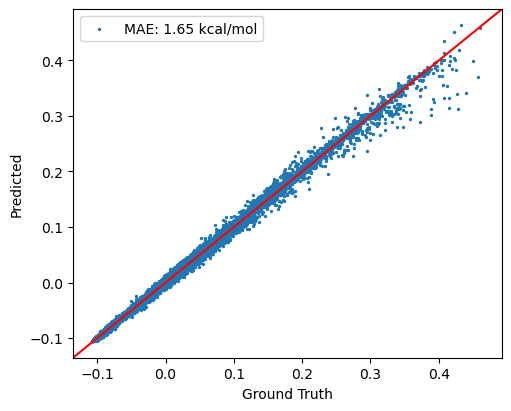

In [7]:
# No regularization, batch size 2048, learning rate 1e-4

trainer_final1 = ANITrainer(
    model=create_model(FeedForwardANI),
    batch_size=2048,
    learning_rate=1e-4,
    epoch=30,
    l2=0.0
)

trainer_final1.train(train_data=train_data, val_data=val_data, early_stop=True, draw_curve=True)
trainer_final1.evaluate(test_data, draw_plot=True)

That was already a lot better than before! I think actually an even larger batch size and learning rate with a bit of regularization might help!

Sequential - Number of parameters: 197636
Initialize training data...


100%|██████████| 20/20 [02:18<00:00,  6.95s/it]


8.876986150283203e-07

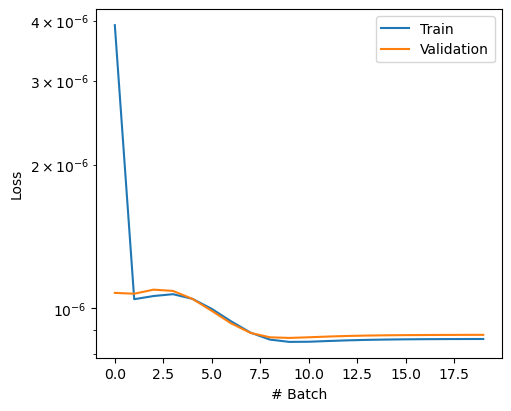

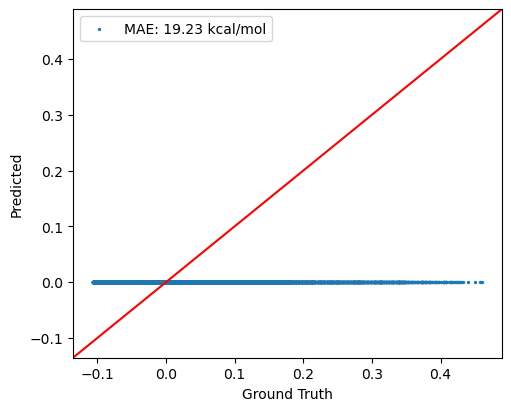

In [8]:
# a bit of regularization of 1e-1, quadrupled batch size, 10 times faster learning rate 1e-3

trainer_final2 = ANITrainer(
    model=create_model(FeedForwardANI),
    batch_size=8192,
    learning_rate=1e-3,
    epoch=20,
    l2=1e-1
)

trainer_final2.train(train_data=train_data, val_data=val_data, early_stop=True, draw_curve=True)
trainer_final2.evaluate(test_data, draw_plot=True)

Ok I think I went way overboard and this model got so over regularized that it became a constant predictor. I will try to get the terms closer to the original. I also think regularization doesn't quite help here? Perhaps it would with better batch normalization but that's out of scope here.

## Model Choice and defense

Overall, I think that a simple feedforward network with 1 hidden layer and CELU activation with alpha = 1 works great with no regularization, batch size 2048, learning rate 1e-4. With some rough tests I've shown that the more complex arcitectures do not nessecarily help as the aev computation already does a massive chunk of relevant prior setting for the model, and everything else at least with my hyperparam choices do not quite help much in having good generalization. The loss here is very low too.